In [1]:
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
PROJECT_ID, DATASET_ID, TABLE_ID = "intern-project-415606", "Criminal_Dataset", "criminal_data_inorder"
bigquery_client = bigquery.Client(project=PROJECT_ID)

In [3]:
# read the (original) data from the bigquery
def read_bq(project_id, dataset_id, table_id):

    query = f"""
        SELECT *
        FROM {project_id}.{dataset_id}.{table_id}
    """

    query_job = bigquery_client.query(query)

    # Convert the result into a Pandas DataFrame
    df = query_job.to_dataframe()

    return df

In [4]:
dataset = read_bq(PROJECT_ID, DATASET_ID, TABLE_ID)
dataset.head()

,extract_id,text,ner_underthesea,tag_underthesea,self_label,sequence
0,12245,toàn bộ,O,L,other,3920855
1,12258,đ,O,Nu,other,3925338
2,12288,đ,O,Nu,other,3934372
3,12288,đồng,O,Nu,other,3934377
4,12344,đ,O,Nu,other,3952606


## Import Libraries

In [5]:
%pip install conlleval
%pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00


In [6]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import os
import keras
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from keras import layers
from collections import Counter
import pickle

## Transformer block layer

In [7]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        print('attn_output1:', attn_output)
        attn_output = self.dropout1(attn_output, training=training)
        print('attn_output2:', attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        print('out1:', out1)
        ffn_output = self.ffn(out1)
        print('ffn_output:', ffn_output)
        ffn_output = self.dropout2(ffn_output, training=training)
        print('ffn_output:', ffn_output)
        return self.layernorm2(out1 + ffn_output)


## Token and Position Embedding Layer

In [8]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

## Data preprocessing

In [9]:
dataset

,extract_id,text,ner_underthesea,tag_underthesea,self_label,sequence
0,12245,toàn bộ,O,L,other,3920855
1,12258,đ,O,Nu,other,3925338
2,12288,đ,O,Nu,other,3934372
3,12288,đồng,O,Nu,other,3934377
4,12344,đ,O,Nu,other,3952606
...,...,...,...,...,...,...
7919533,3331,Quảng Bình,I-LOC,Np,other,1054114
7919534,3332,Sinh,B-PER,Np,other,1054146
7919535,3332,Cao Thị Phương,B-PER,Np,other,1054200
7919536,3333,Hồ Chí Minh,I-LOC,Np,other,1054324


In [10]:
# Eliminate all the CH (punctuation)
dataset = dataset[dataset['tag_underthesea'] != 'CH']

# Define the mapping
label_map = {"N": 0, "M": 1, "other": 2}

# Replace numeric labels with NER labels
dataset.loc[:, 'self_label'] = dataset['self_label'].map(label_map)

dataset

<ipython-input-10-6ea0a256bc1d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'self_label'] = dataset['self_label'].map(label_map)
<ipython-input-10-6ea0a256bc1d>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.loc[:, 'self_label'] = dataset['self_label'].map(label_map)


,extract_id,text,ner_underthesea,tag_underthesea,self_label,sequence
0,12245,toàn bộ,O,L,2,3920855
1,12258,đ,O,Nu,2,3925338
2,12288,đ,O,Nu,2,3934372
3,12288,đồng,O,Nu,2,3934377
4,12344,đ,O,Nu,2,3952606
...,...,...,...,...,...,...
7919533,3331,Quảng Bình,I-LOC,Np,2,1054114
7919534,3332,Sinh,B-PER,Np,2,1054146
7919535,3332,Cao Thị Phương,B-PER,Np,2,1054200
7919536,3333,Hồ Chí Minh,I-LOC,Np,2,1054324


In [11]:
# Sort the DataFrame by the "index" column
dataset = dataset.sort_values(by='sequence')

dataset

,extract_id,text,ner_underthesea,tag_underthesea,self_label,sequence
1365710,0,1,O,M,1,1
5420145,0,Sùng Seo,B-PER,Np,2,3
5250334,0,Q,I-PER,Np,2,4
3025404,0,sinh,O,V,2,6
5698664,0,ngày,B-LOC,N,2,7
...,...,...,...,...,...,...
1631674,24776,năm,B-LOC,N,2,7919529
1367797,24776,2019,I-LOC,M,1,7919530
542116,24776,đến,O,E,2,7919531
2254731,24776,nay,O,P,2,7919532


In [12]:
# Grouping the dataset by 'extract_id' and aggregating the 'text' and 'self_label' columns into lists
grouped_data = dataset.groupby('extract_id').agg({'text': list, 'self_label': list}).reset_index()

# Converting the grouped data into a dictionary
dataset_group = {
    'id': grouped_data['extract_id'].tolist(),
    'token': grouped_data['text'].tolist(),
    'self_tag': grouped_data['self_label'].tolist()
}

# Printing the first group for verification
print('Group ID:', dataset_group['id'][0])
print('Token:', dataset_group['token'][0])
print('Self Tag:', dataset_group['self_tag'][0])

Group ID: 0
Token: ['1', 'Sùng Seo', 'Q', 'sinh', 'ngày', '13/7/2003', 'tại', 'huyện', 'B', 'tỉnh', 'Lào Cai', 'Nơi', 'cư trú', 'Thôn T', 'xã', 'T', 'huyện', 'B', 'tỉnh', 'Lào Cai', 'nghề nghiệp', 'Tự do', 'trình độ', 'học vấn', '9/12', 'dân tộc', 'Mông', 'giới tính', 'Nam', 'tôn giáo', 'Không', 'quốc tịch', 'Việt Nam', 'con', 'ông', 'Sùng Seo', 'P sinh', 'năm', '1974', 'và', 'bà', 'Giàng Thị X', 'sinh', 'năm', '1980', 'vợ', 'chung', 'như', 'vợ chồng', 'với', 'Ly Thị T', 'sinh', 'năm', '1998', 'và', '01', 'con', 'sinh', 'năm', '2021', 'Tiền án', 'Không', 'Tiền sư', '̣', 'Không', 'Ngày', 'bị', 'bắt', 'tạm', 'giữ', '28/4/2022', 'ngày', 'bị', 'bắt', 'tạm', 'giam', '04/5/2022', 'ngày', 'cho', 'tại ngoại', 'Không', 'hiện', 'đang', 'bị', 'tạm', 'giam', 'tại', 'nhà', 'tạm', 'giữ', 'Công an', 'huyện', 'Bắc Hà', 'tỉnh', 'Lào Cai', 'Có mặt']
Self Tag: [1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2

Average length: 228.272510796303
Highest length: 4535
Average length of each sublist: 228.272510796303
Median for sublist lengths: 130.0
Maximum length of each sublist: 4535
Percentage of data less than length of 1000: 97.59454332647212


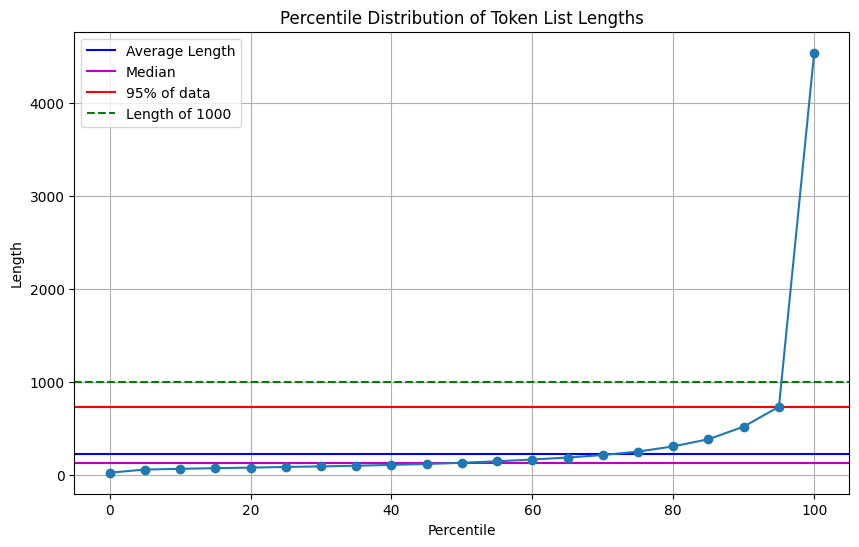

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate average length and highest length of token lists in dataset_group
total_length, highest_length = 0, 0
for token_list in dataset_group['token']:
    # Calculate the length of the current token list
    length = len(token_list)

    # Update total length
    total_length += length

    # Update highest length if necessary
    if length > highest_length:
        highest_length = length

# Calculate average length
if dataset_group['token']:
    average_length = total_length / len(dataset_group['token'])
else:
    average_length = 0

print("Average length:", average_length)
print("Highest length:", highest_length)

# Plotting percentile distribution of token list lengths
lengths = [len(sublist) for sublist in dataset_group['token']]
percentiles = np.arange(0, 101, 5)
percentile_values = np.percentile(lengths, percentiles)
avg_lengths = np.mean(lengths)
quartiles = np.percentile(lengths, [25, 50, 75])
max_lengths = max(lengths)
percentage_less_than_1000 = np.mean(np.array(lengths) <= 1000) * 100

print("Average length of each sublist:", avg_lengths)
print("Median for sublist lengths:", quartiles[1])
print("Maximum length of each sublist:", max_lengths)
print("Percentage of data less than length of 1000:", percentage_less_than_1000)

plt.figure(figsize=(10, 6))
plt.axhline(y=avg_lengths, color='b', linestyle='-', label='Average Length')
plt.axhline(y=quartiles[1], color='m', linestyle='-', label='Median')
plt.axhline(y=percentile_values[-2], color='r', linestyle='-', label='95% of data')
plt.axhline(y=1000, color='g', linestyle='--', label='Length of 1000')  # Added line for length 256
plt.plot(percentiles, percentile_values, marker='o', linestyle='-')
plt.xlabel('Percentile')
plt.ylabel('Length')
plt.title('Percentile Distribution of Token List Lengths')
plt.grid(True)
plt.legend()
plt.show()


In [14]:
# drop the data > 1000
print(print("Number of remaining entries before filtering:", len(dataset_group['id'])))
# Create empty lists to store filtered data
filtered_ids = []
filtered_tokens = []
filtered_self_tags = []

# Iterate through the token lists and their corresponding ids and self_tags
for id, token_list, self_tag_list in zip(dataset_group['id'], dataset_group['token'], dataset_group['self_tag']):
    # Check if the length of the token list is less than or equal to 1000
    if len(token_list) <= 1000:
        # If the length is within the limit, append the id, token list, and self tag list to the filtered lists
        filtered_ids.append(id)
        filtered_tokens.append(token_list)
        filtered_self_tags.append(self_tag_list)

# Update the dataset_group dictionary with the filtered lists
dataset_group['id'] = filtered_ids
dataset_group['token'] = filtered_tokens
dataset_group['self_tag'] = filtered_self_tags

# Print the lengths after filtering
print("Number of remaining entries after filtering:", len(dataset_group['id']))


Number of remaining entries before filtering: 24777
None
Number of remaining entries after filtering: 24181


In [15]:
from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict

# Assuming dataset_group is already constructed as in your previous code

# Convert dataset_group to a DataFrame
import pandas as pd
dataset_df = pd.DataFrame(dataset_group)

# Split data into train and test sets
train_df, test_df = train_test_split(dataset_df, test_size=0.2, random_state=42)

# Create train and test datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Construct DatasetDict
dataset_dict = DatasetDict({'train': train_dataset, 'test': test_dataset})

# Print DatasetDict
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['id', 'token', 'self_tag', '__index_level_0__'],
        num_rows: 19344
    })
    test: Dataset({
        features: ['id', 'token', 'self_tag', '__index_level_0__'],
        num_rows: 4837
    })
})


In [16]:
print(type(dataset_dict['train']['self_tag'][0][0]))

<class 'int'>


## Turn into tensorflow acceptable **datatype**

In [17]:
def export_to_file(export_file_path, data):
    with open(export_file_path, "w") as f:
        for record in data:
            ner_tags = record["self_tag"]
            tokens = record["token"]
            if len(tokens) > 0:
                f.write(
                    str(len(tokens))
                    + "\t"
                    + "\t".join(tokens)
                    + "\t"
                    + "\t".join(map(str, ner_tags))
                    + "\n"
                )
try:
    os.mkdir('./data')
except:
    print('directory exist')
export_to_file("./data/crime_train.txt", dataset_dict['train'])
export_to_file("./data/crime_val.txt", dataset_dict['test'])

In [18]:
def make_tag_lookup_table():
    ner_labels = ["[PAD]", "N", "M", "other"]
    return dict(zip(range(len(ner_labels)), ner_labels))

mapping = make_tag_lookup_table()
print(mapping)

{0: '[PAD]', 1: 'N', 2: 'M', 3: 'other'}


In [19]:
# all_tokens = sum(dataset_dict["train"]["token"], [])
# all_tokens_array = np.array(all_tokens)
all_tokens_array = np.concatenate([np.array(tokens) for tokens in dataset_dict["train"]["token"]])

counter = Counter(all_tokens_array)
print(len(counter))

num_tags = len(mapping)
vocab_size = 80000

# We only take (vocab_size - 2) most common words from the training data since
# the `StringLookup` class uses 2 additional tokens - one denoting an unknown
# token and another one denoting a masking token
vocabulary = [token for token, count in counter.most_common(vocab_size - 2)]

# Save the list to a file
with open('./data/vocabulary.pkl', 'wb') as f:
    pickle.dump(vocabulary, f)


# The StringLookup class will convert tokens to token IDs
lookup_layer = keras.layers.StringLookup(vocabulary=vocabulary)


78224


In [20]:
train_data = tf.data.TextLineDataset("./data/crime_train.txt")
val_data = tf.data.TextLineDataset("./data/crime_val.txt")

In [21]:
print(list(train_data.take(1).as_numpy_iterator()))

[b'241\t1\tPh\xc3\xb9ng Minh T\xc3\xba\tC\tsinh\tng\xc3\xa0y\t11\tth\xc3\xa1ng\t10\tn\xc4\x83m\t1994\tt\xe1\xba\xa1i\thuy\xe1\xbb\x87n\tH\tt\xe1\xbb\x89nh\tL\xe1\xba\xa1ng S\xc6\xa1n\tn\xc6\xa1i\t\xc4\x91\xc4\x83ng k\xc3\xbd\th\xe1\xbb\x99 kh\xe1\xba\xa9u\tth\xc6\xb0\xe1\xbb\x9dng tr\xc3\xba\tv\xc3\xa0\tch\xe1\xbb\x97\t\xe1\xbb\x9f\tTh\xc3\xb4n T\tx\xc3\xa3\t\xc4\x90\thuy\xe1\xbb\x87n\tH\tt\xe1\xbb\x89nh\tL\xe1\xba\xa1ng S\xc6\xa1n\tngh\xe1\xbb\x81 nghi\xe1\xbb\x87p\tLao \xc4\x91\xe1\xbb\x99ng\tt\xe1\xbb\xb1 do\ttr\xc3\xacnh \xc4\x91\xe1\xbb\x99\tv\xc4\x83n h\xc3\xb3a\t12/12\td\xc3\xa2n t\xe1\xbb\x99c\tKinh\tgi\xe1\xbb\x9bi t\xc3\xadnh\tNam\tt\xc3\xb4n gi\xc3\xa1o\tKh\xc3\xb4ng\tqu\xe1\xbb\x91c t\xe1\xbb\x8bch\tVi\xe1\xbb\x87t Nam\tcon\t\xc3\xb4ng\tPh\xc3\xb9ng V\xc4\x83n \xc4\x90\tsinh\tn\xc4\x83m\t1968\tv\xc3\xa0\tb\xc3\xa0\tNguy\xe1\xbb\x85n Th\xe1\xbb\x8b H\tsinh\tn\xc4\x83m\t1969\tc\xc3\xb3\tv\xe1\xbb\xa3\t\xc4\x90o\xc3\xa0n Th\xe1\xbb\x8b T\tsinh\tn\xc4\x83m\t1994\tv\xc3\xa0\t01\

## NER model class

In [22]:
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=1000, embed_dim=32, num_heads=2, ff_dim=32
    ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.dropout2 = layers.Dropout(0.1)
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x

In [28]:
def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    tags += 1
    return tokens, tags


def convert_to_ids(tokens):
    return lookup_layer(tokens)

# We use `padded_batch` here because each record in the dataset has a
# different length.
batch_size = 32

train_dataset = (
    train_data.map(map_record_to_training_data)
    .map(lambda x, y: (convert_to_ids(x), y))
    .padded_batch(batch_size)
)
val_dataset = (
    val_data.map(map_record_to_training_data)
    .map(lambda x, y: (convert_to_ids(x), y))
    .padded_batch(batch_size)
)

ner_model = NERModel(num_tags, vocab_size, embed_dim=32, num_heads=4, ff_dim=64)

In [29]:
train_dataset

<_PaddedBatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [30]:
for a, b in train_dataset:
    print(a)
    print(len(b[0]))
    break

tf.Tensor(
[[   56 42385   109 ...     0     0     0]
 [   82     6    31 ...     0     0     0]
 [21981     3     1 ...     0     0     0]
 ...
 [   82     6    31 ...     0     0     0]
 [   56 17343    31 ...     0     0     0]
 [   81  8214     3 ...     0     0     0]], shape=(32, 971), dtype=int64)
971


## custom loss function

In [26]:
class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, reduction=keras.losses.Reduction.AUTO, name="custom_ner_loss"):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=False, reduction=self.reduction  # Pass the reduction argument here
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

loss = CustomNonPaddingTokenLoss()

## Compile and fit the model

In [31]:
from keras.losses import SparseCategoricalCrossentropy

# Compile the model with a specified loss function and optimizer
ner_model.compile(optimizer="adam", loss=loss)
#ner_model.compile(optimizer="adam", loss=loss)
ner_model.fit(train_dataset, epochs=3)


Epoch 1/5
attn_output1: Tensor("ner_model_1/transformer_block_1/multi_head_attention_1/attention_output/add:0", shape=(None, None, 32), dtype=float32)
attn_output2: Tensor("ner_model_1/transformer_block_1/dropout_4/dropout/SelectV2:0", shape=(None, None, 32), dtype=float32)
out1: Tensor("ner_model_1/transformer_block_1/layer_normalization_2/batchnorm/add_1:0", shape=(None, None, 32), dtype=float32)
ffn_output: Tensor("ner_model_1/transformer_block_1/sequential_1/dense_5/BiasAdd:0", shape=(None, None, 32), dtype=float32)
ffn_output: Tensor("ner_model_1/transformer_block_1/dropout_5/dropout/SelectV2:0", shape=(None, None, 32), dtype=float32)
attn_output1: Tensor("ner_model_1/transformer_block_1/multi_head_attention_1/attention_output/add:0", shape=(None, None, 32), dtype=float32)
attn_output2: Tensor("ner_model_1/transformer_block_1/dropout_4/dropout/SelectV2:0", shape=(None, None, 32), dtype=float32)
out1: Tensor("ner_model_1/transformer_block_1/layer_normalization_2/batchnorm/add_1:0",

In [35]:
ner_model.save("./data/ner_model")

attn_output1: Tensor("ner_model_1/transformer_block_1/multi_head_attention_1/attention_output/add:0", shape=(None, None, 32), dtype=float32)
attn_output2: Tensor("ner_model_1/transformer_block_1/dropout_4/Identity:0", shape=(None, None, 32), dtype=float32)
out1: Tensor("ner_model_1/transformer_block_1/layer_normalization_2/batchnorm/add_1:0", shape=(None, None, 32), dtype=float32)
ffn_output: Tensor("ner_model_1/transformer_block_1/sequential_1/dense_5/BiasAdd:0", shape=(None, None, 32), dtype=float32)
ffn_output: Tensor("ner_model_1/transformer_block_1/dropout_5/Identity:0", shape=(None, None, 32), dtype=float32)
attn_output1: Tensor("multi_head_attention_1/attention_output/add:0", shape=(None, None, 32), dtype=float32)
attn_output2: Tensor("dropout_4/dropout/SelectV2:0", shape=(None, None, 32), dtype=float32)
out1: Tensor("layer_normalization_2/batchnorm/add_1:0", shape=(None, None, 32), dtype=float32)
ffn_output: Tensor("sequential_1/dense_5/BiasAdd:0", shape=(None, None, 32), dtype

In [32]:
def prediction_and_casting(dataset):
    all_true_tag_ids, all_predicted_tag_ids = [], []

    for x, y in dataset:
        if len(x[0]) > 3135:
            continue
        output = ner_model.predict(x, verbose=0)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]
    real_tags = [mapping[tag] for tag in all_true_tag_ids]

    print(len(predicted_tags), len(predicted_tags))
    return predicted_tags, real_tags
    #evaluate(real_tags, predicted_tags)

y_pred, y_val = prediction_and_casting(val_dataset)

attn_output1: Tensor("ner_model_1/transformer_block_1/multi_head_attention_1/attention_output/add:0", shape=(32, 692, 32), dtype=float32)
attn_output2: Tensor("ner_model_1/transformer_block_1/dropout_4/Identity:0", shape=(32, 692, 32), dtype=float32)
out1: Tensor("ner_model_1/transformer_block_1/layer_normalization_2/batchnorm/add_1:0", shape=(32, 692, 32), dtype=float32)
ffn_output: Tensor("ner_model_1/transformer_block_1/sequential_1/dense_5/BiasAdd:0", shape=(32, 692, 32), dtype=float32)
ffn_output: Tensor("ner_model_1/transformer_block_1/dropout_5/Identity:0", shape=(32, 692, 32), dtype=float32)
attn_output1: Tensor("ner_model_1/transformer_block_1/multi_head_attention_1/attention_output/add:0", shape=(32, None, 32), dtype=float32)
attn_output2: Tensor("ner_model_1/transformer_block_1/dropout_4/Identity:0", shape=(32, None, 32), dtype=float32)
out1: Tensor("ner_model_1/transformer_block_1/layer_normalization_2/batchnorm/add_1:0", shape=(32, None, 32), dtype=float32)
ffn_output: Ten

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

def calculate_metrics(y_true, y_pred, labels):
    # Mapping labels to numeric indices
    label_to_index = {label: idx for idx, label in enumerate(labels)}
    index_to_label = {idx: label for label, idx in label_to_index.items()}

    y_true_mapped = [label_to_index[label] for label in y_true]
    y_pred_mapped = [label_to_index[label] for label in y_pred]

    # Overall metrics
    accuracy = accuracy_score(y_true_mapped, y_pred_mapped)
    precision = precision_score(y_true_mapped, y_pred_mapped, average='weighted')
    recall = recall_score(y_true_mapped, y_pred_mapped, average='weighted', zero_division=0)  # Set zero_division to 0
    f1 = f1_score(y_true_mapped, y_pred_mapped, average='weighted')

    # Per-label metrics
    per_label_accuracy = {}
    per_label_precision = {}
    per_label_recall = {}
    per_label_f1 = {}

    for label in labels:
        label_index = label_to_index[label]
        label_indices = [i for i, true_label in enumerate(y_true) if true_label == label]
        if len(label_indices) > 0:
            per_label_accuracy[label] = accuracy_score([y_true_mapped[i] for i in label_indices], [y_pred_mapped[i] for i in label_indices])
            per_label_precision[label] = precision_score([y_true_mapped[i] for i in label_indices], [y_pred_mapped[i] for i in label_indices], average='weighted')
            per_label_recall[label] = recall_score([y_true_mapped[i] for i in label_indices], [y_pred_mapped[i] for i in label_indices], average='weighted', zero_division=0)  # Set zero_division to 0
            per_label_f1[label] = f1_score([y_true_mapped[i] for i in label_indices], [y_pred_mapped[i] for i in label_indices], average='weighted')
        else:
            per_label_accuracy[label] = 0
            per_label_precision[label] = 0
            per_label_recall[label] = 0
            per_label_f1[label] = 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_label_accuracy': per_label_accuracy,
        'per_label_precision': per_label_precision,
        'per_label_recall': per_label_recall,
        'per_label_f1': per_label_f1,
        'index_to_label': index_to_label
    }

#labels
labels = ['M', 'N', 'other']

metrics = calculate_metrics(y_val, y_pred, labels)

# Constructing table
table_data = []
for label in labels:
    table_data.append([label,
                       metrics['per_label_accuracy'][label],
                       metrics['per_label_precision'][label],
                       metrics['per_label_recall'][label],
                       metrics['per_label_f1'][label]])
overall_accuracy = calculate_metrics(y_val, y_pred, labels)
print("Overall Accuracy:".ljust(20), overall_accuracy['accuracy'])
print("Overall Precision:".ljust(20), overall_accuracy['precision'])
print("Overall Recall:".ljust(20), overall_accuracy['recall'])
print("Overall F1-score:".ljust(20), overall_accuracy['f1'])
print(tabulate(table_data, headers=["Label", "Accuracy", "Precision", "Recall", "F1-score"], tablefmt="grid"))


Overall Accuracy:    0.9853944675374
Overall Precision:   0.9849596410091016
Overall Recall:      0.9853944675374
Overall F1-score:    0.9850792294149096
+---------+------------+-------------+----------+------------+
| Label   |   Accuracy |   Precision |   Recall |   F1-score |
+=========+============+=============+==========+============+
| M       |   0.919008 |           1 | 0.919008 |   0.957795 |
+---------+------------+-------------+----------+------------+
| N       |   0.545474 |           1 | 0.545474 |   0.705899 |
+---------+------------+-------------+----------+------------+
| other   |   0.994473 |           1 | 0.994473 |   0.997229 |
+---------+------------+-------------+----------+------------+


In [34]:
#average length of
dataset.describe()

,extract_id,self_label,sequence
count,5655908.0,5.655908e+06,5655908.0
mean,12395.650637,1.896806e+00,3958706.872685
std,7127.905624,3.202710e-01,2286253.081584
min,0.0,0.000000e+00,1.0
25%,6259.0,2.000000e+00,1979060.75
50%,12371.0,2.000000e+00,3959755.0
75%,18575.0,2.000000e+00,5938240.25
max,24776.0,2.000000e+00,7919534.0


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
!cp /content/data/vocabulary.pkl /content/drive/MyDrive/NER/vocabulary.pkl

In [39]:
!cp -r /content/data/ner_model /content/drive/MyDrive/NER/ner_model

In [40]:
import os
os.listdir('drive/MyDrive/NER')

['vocabulary.pkl', 'ner_model']

In [42]:
import re
import pickle
import keras
import tensorflow as tf
import numpy as np

class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, reduction=keras.losses.Reduction.AUTO, name="custom_ner_loss"):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=False, reduction=self.reduction
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    tags += 1
    return tokens, tags

def lookup(tokens):
    # Load the list from the file
    with open('/content/drive/MyDrive/NER/vocabulary.pkl', 'rb') as f:
        loaded_list = pickle.load(f)
    # The StringLookup class will convert tokens to token IDs
    lookup_layer = keras.layers.StringLookup(vocabulary=loaded_list)

    # No need to lowercase Vietnamese characters
    return lookup_layer(tokens)

def format_datatype(data):
    tokens =  [re.sub(r'[;,]', '', d) for d in data.split(' ')]
    #default is 0, since is for prediction
    ner_tags = [0 for d in data.split(' ')]

    #tab to separate
    string_input = str(len(tokens))+ "\t"+ "\t".join(tokens)+ "\t"+ "\t".join(map(str, ner_tags))
    string_input = tf.data.Dataset.from_tensor_slices([string_input])


    finalize_input = (string_input.map(map_record_to_training_data)
                      .map(lambda x, y: (lookup(x),  y))
                      .padded_batch(1)
                      )

    return finalize_input

def prediction(data):
    # Register the custom loss function with TensorFlow
    tf.keras.utils.get_custom_objects()['CustomNonPaddingTokenLoss'] = CustomNonPaddingTokenLoss
    # Load model
    loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/NER/ner_model")

    all_predicted_tag_ids = []

    for x, _ in data:
        print("Input Tensor Info:")
        print("Data Type:", x.dtype)
        print("Shape:", x.shape)
        output = loaded_model(x, training=False)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])
        all_predicted_tag_ids.append(predictions)

    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    ner_labels = ["[PAD]", "N", "M", "other"]
    mapping =  dict(zip(range(len(ner_labels)), ner_labels))
    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]

    return predicted_tags

sample_input = "1/ Trần Văn T, sinh ngày 01 tháng 01 năm 1987 tại Quảng Nam; Nơi cư trú: thôn 04, xã TG, huyện Bắc Trà My, tỉnh Quảng Nam; nghề nghiệp: nông; trình độ văn hoá: 03/12; dân tộc: Cadong; giới tính: nam; tôn giáo: không; quốc tịch: Việt Nam; con ông Trần Văn Tiếu và bà Thanh Thị Liên; vợ tên Phạm Thị Hiếm và 02 con; tiền án, tiền sự: không; Bị cáo bị áp dụng biện pháp ngăn chặn: “Cấm đi khỏi nơi cư trú”, có mặt tại phiên tòa. 2/ Đinh Tấn M, sinh ngày 21 tháng 6 năm 1995 tại Quảng Nam; Nơi cư trú: thôn 04, xã TG, huyện Bắc Trà My, tỉnh Quảng Nam; nghề nghiệp: nông; trình độ"
#sample_input = "Hello world, my name is John, I live in New York, my birthday is 10/02/1990."
#sample_input = "<Page:1>TÒA ÁN NHÂN DÂN CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM HUYỆN LỆ THỦY Độc lập - Tự do - Hạnh phúc TỈNH QUẢNG BÌNH Bản án số: 50/2020/HS-ST Ngày 30 - 9 - 2020 NHÂN DANH NƯỚC CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM TÒA ÁN NHÂN DÂN HUYỆN LỆ THUỶ, TỈNH QUẢNG BÌNH - Thành phần Hội đồng xét xử sơ thẩm gồm có: Chủ tọa phiên tòa: Ông Nguyễn Thanh Hải. Các Hội thẩm nhân dân: Ông Lê Ngọc Thành và ông Trương Hải Nam. - Thư ký Tòa án ghi biên bản phiên tòa: Bà Nguyễn Thị Hoài Thương - Thư ký Toà án nhân dân huyện Lệ Thuỷ, tỉnh Quảng Bình. - Đại diện Viện kiểm sát nhân dân huyện Lệ Thủy tham gia phiên tòa: Bà Nguyễn Thị Diệp - Kiểm sát viên. Trong ngày 30 tháng 9 năm 2020, tại trụ sở Toà án nhân dân huyện Lệ Thuỷ, tỉnh Quảng Bình xét xử sơ thẩm công khai vụ án hình sự sơ thẩm thụ lý số 50/TLST-HS ngày 04 tháng 9 năm 2020 theo Quyết định đưa vụ án ra xét xử số: 53/2020/QĐXXST-HS ngày 16 tháng 9 năm 2020. 1. Nguyễn Hải Q; Sinh ngày 20 tháng 2 năm 1990 tại Quảng Bình. Nơi cư trú: Thôn L, xã Tr, huyện L, tỉnh Quảng Bình; nghề nghiệp: Lao động tự do; trình độ học vấn: Lớp 12/12; dân tộc: Kinh; giới tính: Nam; tôn giáo: không; quốc tịch: Việt Nam; con ông Nguyễn Hữu D (đã chết) và bà Mai Thị H; có vợ Lê Thị K, sinh năm 1991 và có 01 con sinh năm 2014; tiền án, tiền sự: không; bị tạm giữ 09 ngày, từ ngày 13/6/2020 đến ngày 22/6/2020; hiện tại bị áp dụng biện pháp ngăn chặn cấm đi khỏi nơi cư trú, có mặt. 2. Võ Văn D; Sinh ngày 12 tháng 12 năm 1983 tại Quảng Bình; Nơi cư trú: Thôn X, xã M, huyện L, tỉnh Quảng Bình; nghề nghiệp: Lái máy công trình xây dựng; trình độ học vấn: Lớp 9/12; dân tộc: Kinh; giới tính: Nam; tôn giáo: không; quốc tịch: Việt Nam; con ông Võ Văn B và bà Trương Thị H; có vợ Nguyễn Thị Ngọc L, sinh năm 1985 và có 02 con, lớn sinh năm 2009, nhỏ sinh năm 2016; tiền án, tiền sự: không; bị tạm giữ 09 ngày, từ ngày 13/6/2020 đến ngày 22/6/2020; hiện tại bị áp dụng biện pháp ngăn chặn cấm đi khỏi nơi cư trú, có mặt. 3. Nguyễn Văn Th; Sinh ngày: 20 tháng 6 năm 1988 tại Quảng Bình. Nơi cư trú: Thôn L, xã M, huyện L, tỉnh Quảng Bình; nghề nghiệp: Lái xe; trình độ học vấn: Lớp 12/12; dân tộc: Kinh; giới tính: Nam; tôn giáo: không; quốc tịch: Việt Nam; con ông Nguyễn Văn M và bà Nguyễn Thị D; chưa có vợ, con; tiền án, tiền sự: không; bị tạm giữ 09 ngày, từ ngày 13/6/2020 đến ngày 22/6/2020; hiện tại bị áp dụng biện pháp ngăn chặn cấm đi khỏi nơi cư trú, có mặt. 4. Lê Trung Th; Sinh ngày 20 tháng 01 năm 1960 tại Quảng Bình.<Page:2>Nơi cư trú: Thôn L, xã M, huyện L, tỉnh Quảng Bình; nghề nghiệp: Lao động tự do; trình độ học vấn: Lớp 10/10; dân tộc: Kinh; giới tính: Nam; tôn giáo: không; quốc tịch: Việt Nam; con ông Lê Văn Ng và bà Hoàng Thị H (hiện hai ông bà đã chết); có vợ Trần Thị Th, sinh năm 1965 và có 05 con, lớn nhất sinh năm 1987 nhỏ nhất sinh năm 2003; tiền án, tiền sự: không; bị tạm giữ 09 ngày, từ ngày 13/6/2020 đến ngày 22/6/2020; hiện tại bị áp dụng biện pháp ngăn chặn cấm đi khỏi nơi cư trú, có mặt. * "
result = prediction(format_datatype(sample_input))
print(result)
print(sample_input.split(' '))
print(len(result))

Input Tensor Info:
Data Type: <dtype: 'int64'>
Shape: (1, 125)
['[PAD]', 'other', '[PAD]', 'other', 'other', 'other', 'M', 'other', 'M', 'other', 'M', 'other', 'other', 'other', 'other', 'other', '[PAD]', 'other', 'other', 'other', 'other', 'other', 'other', '[PAD]', 'other', 'other', 'other', 'other', 'other', '[PAD]', 'other', 'other', 'other', 'other', 'other', 'other', 'other', '[PAD]', 'other', 'other', '[PAD]', 'other', 'other', '[PAD]', 'other', 'other', '[PAD]', 'other', 'other', 'other', 'other', 'other', '[PAD]', '[PAD]', 'other', 'other', 'other', '[PAD]', 'other', 'other', 'other', 'other', '[PAD]', '[PAD]', 'other', 'other', 'other', 'other', 'other', 'other', '[PAD]', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', '[PAD]', '[PAD]', 'other', 'other', 'other', 'other', '[PAD]', 'other', 'other', 'other', 'other', '[PAD]', '[PAD]', 'other', '[PAD]', 'other', 'other', 'other', 'M', 'other', 'M', 'other', 'M', 'other', 'other', 'other', 'other